In [1]:
import numpy as np
import scipy as sp
from pathlib import Path
import multiprocessing

import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams.update({'font.size': 16})

import corner
from iminuit import Minuit

from mcmc import metropolis_hastings
from plot import plot_2d_pdf_contour

np.random.seed(1)

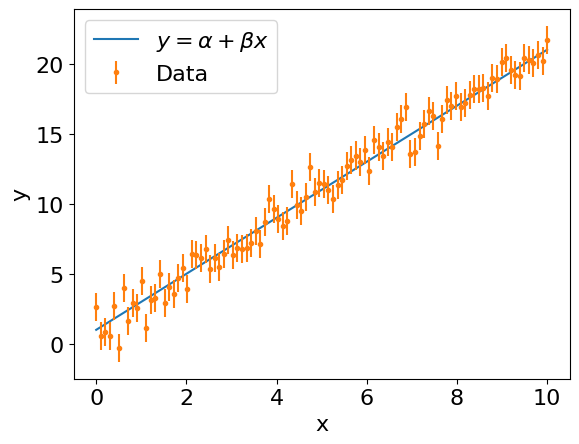

In [2]:
x = np.linspace(0,10, 100)
t0, t1 = 1,2
y = t0 + t1*x
data = y + np.random.normal(0, 1, size=len(y))

plt.plot(x,y, label = r'$y=\alpha+\beta x$')
plt.errorbar(x,data, 1, fmt='.', label='Data')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()

plt.savefig('plots/linear_data.pdf', bbox_inches='tight')

In [3]:
def nll(theta0, theta1, x, y, yerr=1):
    '''
    -2*log(p(data|theta))
    '''
    y_pred = theta0 + theta1 * x
    residuals = y - y_pred
    return np.sum((residuals / yerr)**2)

def nlprior(theta0, theta1):
    '''
    -2*log(p(theta))
    '''
    p0 = 0 if 0 <= theta0 <= 2 else np.inf
    sigma1 = 0.03
    p1 = ((theta1-t1)/sigma1)**2
    return p0+p1

def nlposterior(theta0, theta1, x, y):
    '''
    -2*log(p(theta|data))
    '''
    return nll(theta0, theta1, x, y) + nlprior(theta0, theta1)

# Frequentist analysis

In [4]:
nll_unconstr = lambda t0, t1: nll(t0, t1, x, y)

m = Minuit(nll_unconstr, 1,1, name=(r'$\alpha$', r'$\beta$'))
m.migrad()
m.hesse()

/home/lorenz/presentations/icsc-bayesian-inference/.venv/lib/python3.12/site-packages/iminuit/_repr_text.py:245: OptionalDependencyWarning: rendering simple LaTeX requires optional package 'unicodeitplus'. Install 'unicodeitplus' manually to enable this functionality.
  with optional_module_for("rendering simple LaTeX"):


┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 5.907e-23                  │              Nfcn = 46               │
│ EDM = 5.91e-23 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name     │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ $\alpha$ │    1.0    │    0.2    │            │            │         │         │       │
│ 1 │ $\beta$  │   2.000   │   0.034   │            │            │         │         │       │
└───┴──────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌──────────┬───────────────────┐
│          │ $\alpha$  $\beta$ │
├──────────┼───────────────────┤
│ $\alpha$ │   0.0394  -0.0059 │
│  $\beta$ │  -0.0059  0.00118 │
└──────────┴───────────────────┘

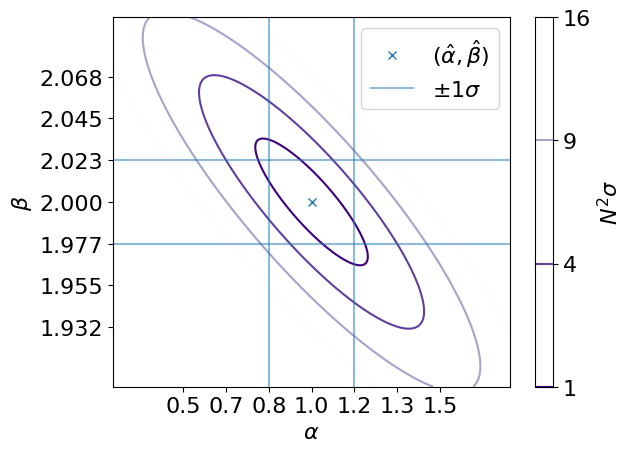

In [22]:
sigmax = [m.values[0], m.errors[0]]
sigmay = [m.values[1], m.errors[1]]

plot_2d_pdf_contour(
    nll_unconstr, 
    x_sigma=sigmax, 
    y_sigma=sigmay, 
    x_label=r'$\alpha$', 
    y_label=r'$\beta$',
    mode_label=r'$(\hat\alpha, \hat \beta)$',
    file='plots/nll_unconstr.pdf'
    )

In [18]:
nll_constr = lambda th0, th1: nlposterior(th0, th1, x, y)

m = Minuit(nll_constr, 1,1, name=(r'$\alpha$', r'$\beta$'))
m.migrad()
m.hesse()

/home/lorenz/presentations/icsc-bayesian-inference/.venv/lib/python3.12/site-packages/iminuit/_repr_text.py:245: OptionalDependencyWarning: rendering simple LaTeX requires optional package 'unicodeitplus'. Install 'unicodeitplus' manually to enable this functionality.
  with optional_module_for("rendering simple LaTeX"):


┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 3.517e-26                  │              Nfcn = 110              │
│ EDM = 3.51e-26 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name     │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ $\alpha$ │   1.00    │   0.15    │            │            │         │         │       │
│ 1 │ $\beta$  │   2.000   │   0.023   │            │            │         │         │       │
└───┴──────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌──────────┬───────────────────┐
│          │ $\alpha$  $\beta$ │
├──────────┼───────────────────┤
│ $\alpha$ │   0.0227  -2.5e-3 │
│  $\beta$ │  -2.5e-3  0.00051 │
└──────────┴───────────────────┘

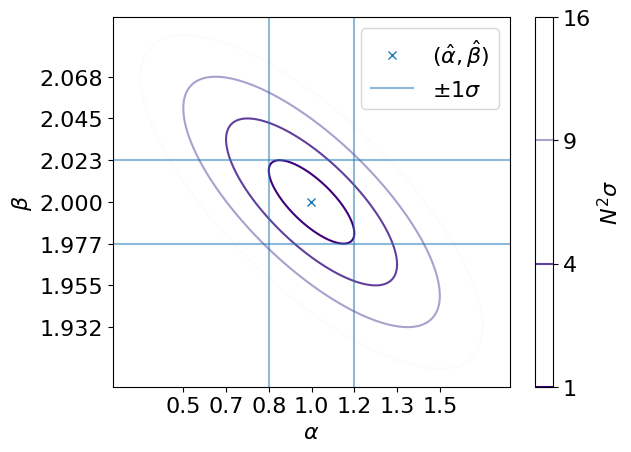

In [21]:
sigmax = [m.values[0], m.errors[0]]
sigmay = [m.values[1], m.errors[1]]

plot_2d_pdf_contour(
    nll_constr, 
    x_sigma=sigmax, 
    y_sigma=sigmay, 
    x_label=r'$\alpha$', 
    y_label=r'$\beta$',
    mode_label=r'$(\hat\alpha, \hat \beta)$',
    file='plots/nll_constr.pdf'
    )

# Bayesian analysis

In [8]:
# Parameters for MCMC
iterations = 500000
chains=8

nlpost = lambda pars: nlposterior(*pars, x, y)

# Random initial values for each chain
initial_points = [
    [np.random.uniform(0, 2), np.random.uniform(0, 4)] for _ in range(chains)
]

def run_chain(initial_point):
    chain = metropolis_hastings(nlpost, iterations, initial_point)
    return chain

with multiprocessing.Pool(processes=chains) as pool:
    chains = pool.map(run_chain, initial_points)

samples = np.vstack(chains)


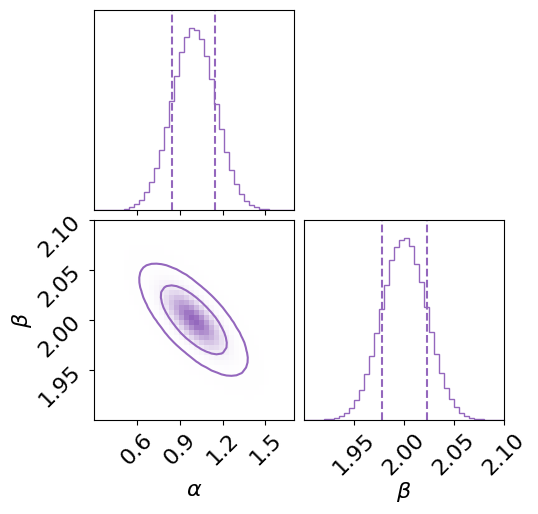

In [9]:
fig = corner.corner(
    samples,
    bins=40,
    range=[(0.3,1.7), (1.9,2.1)],
    levels=(0.68, 0.95),
    quantiles=(0.16, 0.84),
    smooth=1.0,
    plot_datapoints=False,
    labels=[r'$\alpha$', r'$\beta$'],
    color='tab:purple',
    );

file='plots/posterior.pdf'
fig.savefig(file)

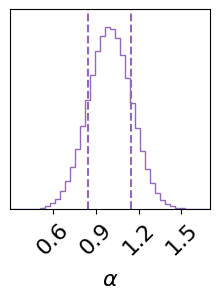

In [10]:
fig = corner.corner(
    samples[:,0],
    bins=40,
    range=[(0.3,1.7)],
    levels=(0.68, 0.95),
    quantiles=(0.16, 0.84),
    smooth=1.0,
    plot_datapoints=False,
    labels=[r'$\alpha$', r'$\beta$'],
    color='tab:purple',
    );

file='plots/marginal_posterior.pdf'
fig.savefig(file)

In [11]:
np.mean(samples[:,0]), np.std(samples[:,0])

(np.float64(0.9979527431130525), np.float64(0.15135169648537913))

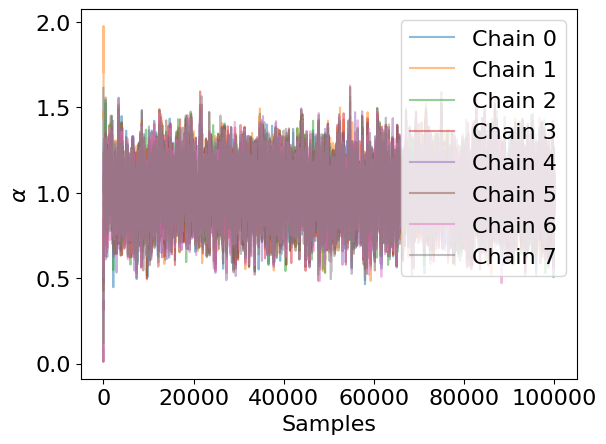

In [27]:
for i,c in enumerate(chains):
    plt.plot(c[:100000,0], alpha=0.5, label=f'Chain {i}')

plt.xlabel(r'Samples')
plt.ylabel(r'$\alpha$')
plt.legend(loc='upper right')

file='plots/trace_theta0.pdf'
plt.savefig(file, bbox_inches='tight')

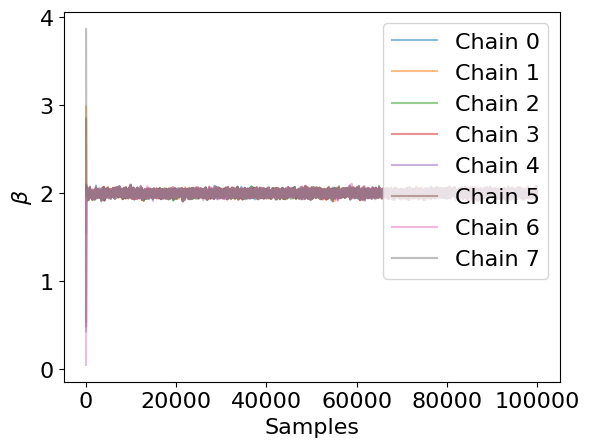

In [28]:
for i,c in enumerate(chains):
    plt.plot(c[:100000,1], alpha=0.5, label=f'Chain {i}')

plt.xlabel(r'Samples')
plt.ylabel(r'$\beta$')
plt.legend(loc='upper right')

file='plots/trace_theta1.pdf'
plt.savefig(file, bbox_inches='tight')

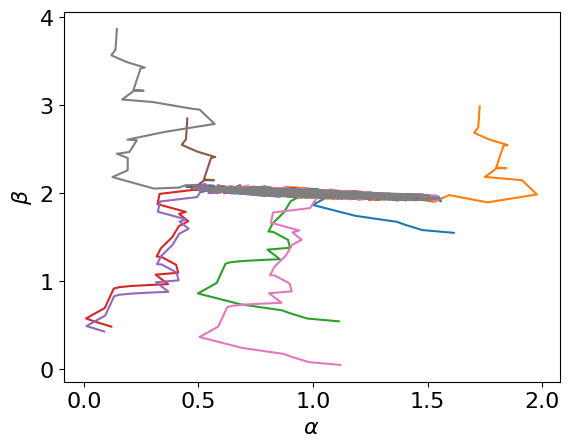

In [23]:
for i, c in enumerate(chains):
    plt.plot(*c[:10000].T, label=f'Process {i}')
plt.xlabel(r'$\alpha$')
plt.ylabel(r'$\beta$')

# plt.legend(loc='upper right')

file='plots/chain_walk.pdf'
plt.savefig(file, bbox_inches='tight')